In [1]:
import numpy as np
import pandas as pd

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#plots
import matplotlib.pyplot as plt
from plotnine import *
from mizani import *

#stats
import scipy as sp
import statsmodels as sm

import warnings
warnings.filterwarnings('ignore')
import collections

In [2]:
def gen_campaigns(p1,p2,nb_days,scaler,seed):
    #generate fake data
    np.random.seed(seed)
    ns = np.random.triangular(50,100,150,size=nb_days*2).astype(int)
    np.random.seed(seed)
    es = np.random.randn(nb_days*2) / scaler

    n1 = ns[:nb_days]
    c1 = ((p1 + es[:nb_days]) * n1).astype(int)
    n2 = ns[nb_days:]
    c2 = ((p2 + es[nb_days:]) * n2).astype(int)
    conv_days = pd.DataFrame({'click_day':range(nb_days),'click_a':n1,'conv_a':c1,'click_b':n2,'conv_b':c2})

    conv_days =  conv_days[['click_day','click_a','click_b','conv_a','conv_b']]
    conv_days['cumu_click_a'] = conv_days.click_a.cumsum()
    conv_days['cumu_click_b'] = conv_days.click_b.cumsum()
    conv_days['cumu_conv_a'] = conv_days.conv_a.cumsum()
    conv_days['cumu_conv_b'] = conv_days.conv_b.cumsum()
    conv_days['cumu_rate_a'] = conv_days.cumu_conv_a / conv_days.cumu_click_a
    conv_days['cumu_rate_b'] = conv_days.cumu_conv_b / conv_days.cumu_click_b
    return conv_days

conv_days = gen_campaigns(p1 = 0.10,
                          p2 = 0.105,
                          nb_days = 24,
                          scaler=300,
                          seed = 1412) #god-mode 
conv_days.head()

,click_day,click_a,click_b,conv_a,conv_b,cumu_click_a,cumu_click_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b
0,0,125,87,12,9,125,87,12,9,0.096000,0.103448
1,1,114,86,11,9,239,173,23,18,0.096234,0.104046
2,2,67,91,6,9,306,264,29,27,0.094771,0.102273
3,3,96,103,9,10,402,367,38,37,0.094527,0.100817
4,4,89,125,9,13,491,492,47,50,0.095723,0.101626


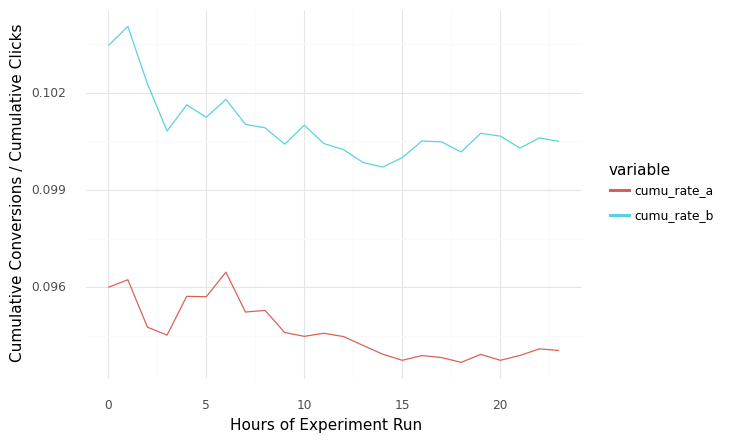

<ggplot: (-9223371948165264966)>

In [3]:
rates_df = conv_days[['click_day','cumu_rate_a','cumu_rate_b']].melt(id_vars='click_day')
g = (ggplot(rates_df, aes(x='click_day', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Hours of Experiment Run') + ylab('Cumulative Conversions / Cumulative Clicks'))
g

In [4]:
#sum after 2 months
conv_df = pd.DataFrame({'campaign_id':['A','B'], 'clicks':[conv_days.click_a.sum(),conv_days.click_b.sum()],
                        'conv_cnt':[conv_days.conv_a.sum(),conv_days.conv_b.sum()]})
conv_df['conv_per'] =  conv_df['conv_cnt'] / conv_df['clicks']
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,2488,234,0.094051
1,B,2209,222,0.100498


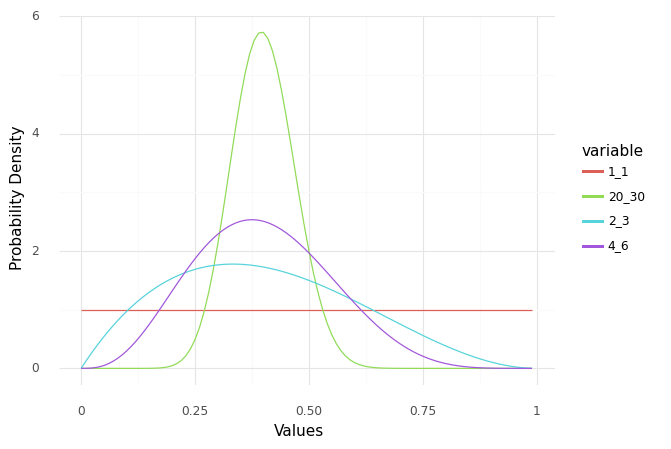

<ggplot: (88691784859)>

In [5]:
beta_df = pd.DataFrame({'x': [i/100 for i in range(100)],
                        '1_1': [sp.stats.beta.pdf(i/100, a=1,b=1) for i in range(100)],
                        '2_3': [sp.stats.beta.pdf(i/100, a=2,b=3) for i in range(100)],
                        '4_6': [sp.stats.beta.pdf(i/100, a=4,b=6) for i in range(100)],
                        '20_30': [sp.stats.beta.pdf(i/100, a=20,b=30) for i in range(100)],
                       }).melt(id_vars='x')
g = (ggplot(beta_df,aes(x='x',y='value',color='variable')) +
     geom_line() + theme_minimal() +
     xlab('Values') + ylab('Probability Density')
    )
g

In [6]:
def plot_beta(a=1,b=9,scaler=1):
    beta_df = pd.DataFrame({'x': [i/100 for i in range(100)],
                           'value': [sp.stats.beta.pdf(i/100, a=a*scaler,b=b*scaler) for i in range(100)]})
    g = (ggplot(beta_df,aes(x='x',y='value')) +
         geom_line() + theme_minimal() +
         xlab('Values') + ylab('Probability Density') +
         ggtitle(f'alpha = {a*scaler}; beta={b*scaler}') 
        )
    return g

widgets.interact(plot_beta, 
                 a=widgets.IntSlider(min=1,max=100,step=1,value=1),
                 b=widgets.IntSlider(min=1,max=100,step=1,value=9),
                 scaler=widgets.FloatSlider(min=0.1,max=100,step=0.5,value=1))

interactive(children=(IntSlider(value=1, description='a', min=1), IntSlider(value=9, description='b', min=1), …

<function __main__.plot_beta(a=1, b=9, scaler=1)>

In [7]:
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,2488,234,0.094051
1,B,2209,222,0.100498


In [9]:
def plot_posterior(clicks, conv_cnt, a = 1, b = 1, scaler=1):
    beta_df = pd.DataFrame({'x': [i/100 for i in range(100)]})
    if not isinstance(a, collections.MutableSequence):
        a = [a for i in range(len(clicks))]
        b = [b for i in range(len(clicks))]
    for v in range(len(clicks)):
        beta_df[f'value_{v}'] = [sp.stats.beta.pdf(i/100, a=a[v]*scaler + conv_cnt[v], \
                                 b=b[v]*scaler + clicks[v] - conv_cnt[v]) for i in range(100)]
    beta_df = beta_df.melt(id_vars='x')
    g = (ggplot(beta_df,aes(x='x',y='value',color='variable',group='variable')) +
         geom_line() + theme_minimal() +
         xlab('Values') + ylab('Probability Density') +
         ggtitle(f'alpha = {[i*scaler for i in a]}; beta={[i*scaler for i in b]}')
        )
    return g

widgets.interact(plot_posterior, 
                 clicks=fixed(conv_df.clicks),
                 conv_cnt=fixed(conv_df.conv_cnt),
                 a=widgets.IntSlider(min=1,max=1000,step=1,value=999),
                 b=widgets.IntSlider(min=1,max=1000,step=1,value=1),
                 scaler=widgets.FloatSlider(min=1,max=100,step=1,value=1))

interactive(children=(IntSlider(value=999, description='a', max=1000, min=1), IntSlider(value=1, description='…

<function __main__.plot_posterior(clicks, conv_cnt, a=1, b=1, scaler=1)>

In [10]:
def sample_proportion(c,n,a=1,b=1,sim_size=100000): return np.random.beta(c+a,n-c+b,sim_size)
def proportion_test_b(c1,c2,n1,n2,a1=1,a2=1,b1=9,b2=9,sim_size=100000):
    p1 = sample_proportion(c1,n1,a1,b1,sim_size)
    p2 = sample_proportion(c2,n2,a2,b2,sim_size)
    return (p1 > p2).mean()
def proportion_ratio(c1,c2,n1,n2,a1=1,a2=1,b1=9,b2=9,sim_size=100000):
    p1 = sample_proportion(c1,n1,a1,b1,sim_size)
    p2 = sample_proportion(c2,n2,a2,b2,sim_size)
    return p1/p2
def proportion_ci_b(c1,c2,n1,n2,p_value=0.05,a1=1,a2=1,b1=9,b2=9,sim_size=100000):
    ratios = proportion_ratio(c1,c2,n1,n2,a1,a2,b1,b2,sim_size)
    return np.quantile(ratios,[p_value/2,1-p_value/2])

p_value= proportion_test_b(*conv_df.conv_cnt,*conv_df.clicks)
ratios = proportion_ratio(*conv_df.conv_cnt,*conv_df.clicks)
credible = proportion_ci_b(*conv_df.conv_cnt,*conv_df.clicks,p_value=0.05)
print(f'Probability that A is greater than B: {p_value}')
print(f'Average A/B ratio: {ratios.mean()}')
print(f'Credible interval of A/B ratio: {credible}')

Probability that A is greater than B: 0.22743
Average A/B ratio: 0.9394908467261973
Credible interval of A/B ratio: [0.78622231 1.11331594]


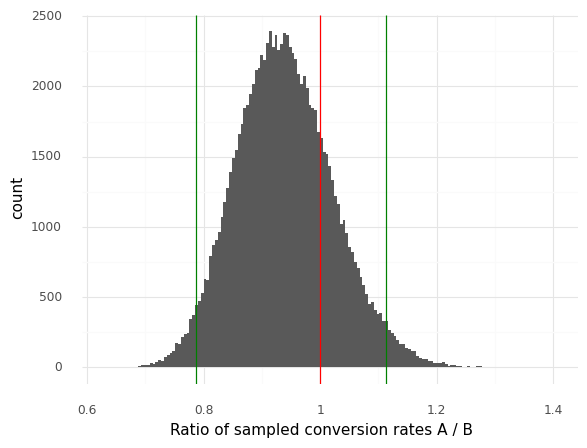

<ggplot: (88689551231)>

In [11]:
g = (ggplot(pd.DataFrame({'x':ratios}), aes(x='x')) + geom_histogram() +
    theme_minimal() + geom_vline(xintercept=1,color='red') +
    geom_vline(xintercept=credible[0],color='green') + geom_vline(xintercept=credible[1],color='green') + 
    xlab('Ratio of sampled conversion rates A / B')
    ) 
g

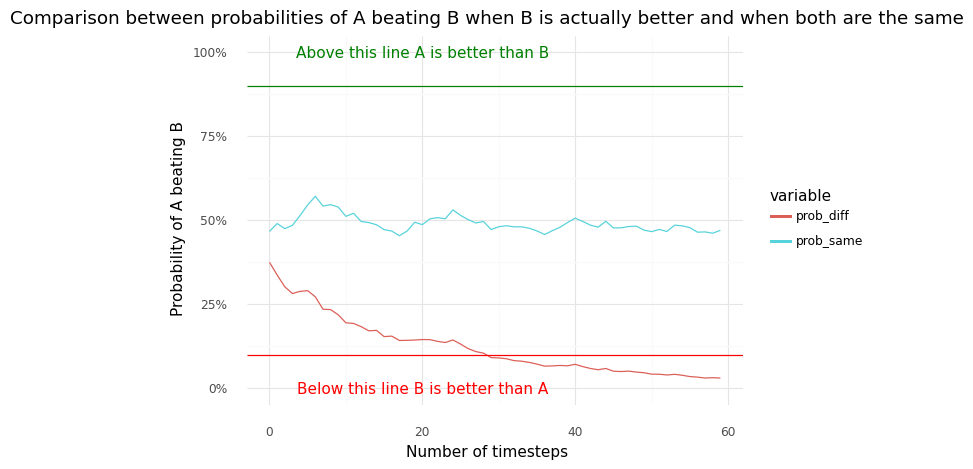

<ggplot: (88691933174)>

In [12]:
conv_days2 = gen_campaigns(p1 = 0.10,
                          p2 = 0.10,
                          nb_days = 60,
                          scaler=300,
                          seed = 1412) #god-mode 
conv_days2['prob_same'] = conv_days2.apply(lambda row: proportion_test_b(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
conv_days3 = gen_campaigns(p1 = 0.10,
                          p2 = 0.11,
                          nb_days = 60,
                          scaler=300,
                          seed = 1412) #god-mode 

conv_days3['prob_diff'] = conv_days3.apply(lambda row: proportion_test_b(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
prob_df = pd.DataFrame({'click_day':conv_days2.click_day,'prob_same':conv_days2.prob_same,
                        'prob_diff':conv_days3.prob_diff}).melt(id_vars='click_day')
g = (ggplot(prob_df,aes(x='click_day',y='value',color='variable')) +
    geom_line() + theme_minimal() + 
    geom_hline(yintercept=[0.9,0.1],color=['green','red']) +
    xlab('Number of timesteps') + ylab('Probability of A beating B') +
    scale_y_continuous(labels=formatters.percent_format()) +
    annotate("text", label = "Above this line A is better than B", x = 20, y = 1, color = 'green') +
    annotate("text", label = "Below this line B is better than A", x = 20, y = 0, color = 'red') +
    ggtitle('Comparison between probabilities of A beating B when B is actually better and when both are the same')
    )
g


In [13]:
def value_remaining(c1,c2,n1,n2,q=95,sim_size=100000,a1=1,a2=1,b1=9,b2=9):
    p1 = sample_proportion(c1,n1,a1,b1,sim_size)[:,None]
    p2 = sample_proportion(c2,n2,a2,b2,sim_size)[:,None]
    p = np.concatenate([p1,p2],1)
    p_max = p.max(1)
    best_idx = np.argmax([p1.mean(),p2.mean()])
    p_best = p[:,best_idx]
    vs = (p_max-p_best)/p_best
    return np.percentile(vs,q)

value_remaining(*conv_df.conv_cnt,*conv_df.clicks)

0.0835620586721222

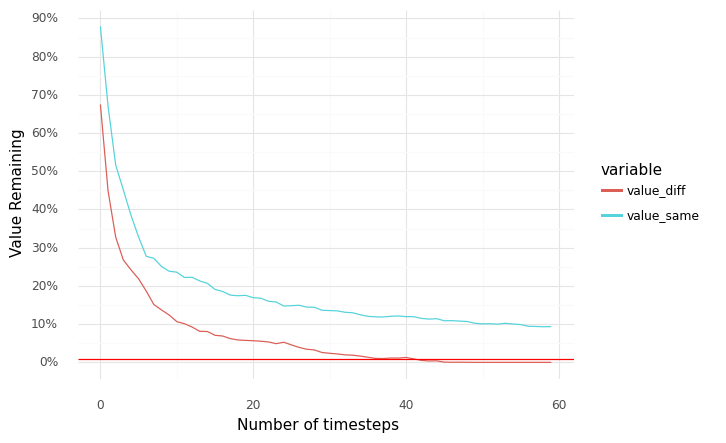

<ggplot: (-9223371948163050117)>

In [14]:
conv_days2['value_remaining'] = conv_days2.apply(lambda row: value_remaining(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
conv_days3['value_remaining'] = conv_days3.apply(lambda row: value_remaining(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
value_df = pd.DataFrame({'click_day':conv_days2.click_day,'value_same':conv_days2.value_remaining,
                        'value_diff':conv_days3.value_remaining}).melt(id_vars='click_day')
g = (ggplot(value_df,aes(x='click_day',y='value',color='variable')) +
    geom_line() + theme_minimal() + 
    geom_hline(yintercept=0.01, color='red') +
    scale_y_continuous(labels=formatters.percent_format(), breaks=[i/100 for i in range(0,101,10)]) +
    xlab('Number of timesteps') + ylab('Value Remaining') 
    )
g